#### Imports

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import math
import control as ct

s = ct.TransferFunction.s
%matplotlib inline
import emcee
import time
from multiprocessing import Pool
import corner

#experiment params
set_t = 77

#### Functions to run the show

##### Scaling

In [30]:
def unnormalise(tempcol_normalized, set_t):
    templist = list(max(tempcol) - (tempcol_normalized * (max(tempcol) - set_t)))
    return templist

In [31]:
def normalise(tempcol, set_t):
    templist = list((max(tempcol) - np.array(tempcol)) / (max(tempcol) - set_t))
    return templist

##### log file reader

In [32]:
def log_file_reader(filename):

    # Load data from file
    datetimecol = []
    tempcol = []
    
    
    try:
        with open(filename) as f:
            for line in f:
                temp = line.strip().split()
                datetimecol.append(temp[0] + ' ' + temp[1])
                tempcol.append(float(temp[2]))
        
        # Convert datetime strings to datetime objects
        time_series = pd.to_datetime(datetimecol)
        
        # Calculate elapsed time in seconds since the start
        elapsed_time_seconds = (time_series - time_series[0]).total_seconds()        
        return [elapsed_time_seconds, tempcol]
    
    except:
        with open(filename) as f:
            for line in f:
                temp = line.strip().split(',')
                datetimecol.append(temp[0]) 
                tempcol.append(float(temp[1]))
        
        # Convert datetime strings to datetime objects
        time_series = pd.to_datetime(datetimecol)
        
        # Calculate elapsed time in seconds since the start
        elapsed_time_seconds = (time_series - time_series[0]).total_seconds()    
        return [elapsed_time_seconds, tempcol]

##### charecterize

In [33]:
def characterize(time, y, set_t):
    
    '''To charecterize a time response and get 
    its model parameters'''
    
    # Find peak temperature and peak time
    y_peak = min(y)
    index_peak = y.index(y_peak)
    peak_time = (time[index_peak])
        
    overshoot = ((y_peak - set_t)/set_t)     
    damp_f = math.sqrt( 1 / ( 1 + ( (math.pi**2) / ((math.log(np.abs(overshoot)))**2) )))
    w_n = math.pi / (peak_time * math.sqrt(1 - (damp_f ** 2)))    
    theta = (math.atan(math.sqrt((1-(damp_f**2))/damp_f)))
    rise_time = (math.pi - theta)/(w_n * math.sqrt(1-(damp_f**2)))
    
    print("Peak temperature:", y_peak, "K")
    print("Percentage overshoot:", round((overshoot*100), 3), "%")
    print("Peak time:", round(peak_time, 3), "s")
    print("Rise time:", round(rise_time, 3), "s")    
    print("Damping Factor:", round(damp_f,8))
    print("Natural Frequency:", round(w_n,8), "rad/s")

    return [y_peak, peak_time, overshoot, rise_time, damp_f, w_n]

##### custom copper model maker

In [34]:
def custom_model_maker(P, C, copper_plate_TF, start_time, end_time):
    T = ct.feedback(C * P * copper_plate_TF, 1)
    print(T)
    time = list(np.arange(start_time, end_time, 0.01))
    _, y = ct.step_response(T, time)
    #print(y)
    y_unnorm = unnormalise(y, set_t)
        
    return time, y_unnorm, T

##### model and tuned system maker

In [35]:
def model_and_tuned_system_maker(w_n, damp_f, kp, ki, kd, kp_new, ki_new, kd_new, kp_tuned, ki_tuned, kd_tuned, start_time, end_time):
    '''
    Good old code that shall remove previous PID, hence extracting Plant, add new PID TF
    Alongside getting the model response, it also takes in tuned kp ki kd values and 
    gives the tuned system response
    '''
    
    P = (w_n ** 2) / (((s ** 2) * kd + s * kp + ki) * (s + 2 * w_n * damp_f))  
    
    #add new pid (model the present system)
    C = ct.TransferFunction([kd_new, kp_new, ki_new], [1, 0])
    T = ct.feedback(C * P, 1)
    
    t_model = list(np.arange(start_time, end_time, 0.01))
    _, y_model = ct.step_response(T, t_model)
    y_model_unnorm = unnormalise(y_model, set_t)
        
    C_tuned = ct.TransferFunction([kd_tuned, kp_tuned, ki_tuned], [1, 0])
    T_tuned = ct.feedback(C_tuned * P, 1)
    
    t_tuned = list(np.arange(start_time, end_time, 0.01))
    _, y_tuned = ct.step_response(T_tuned, t_tuned)
    y_tuned_unnorm = unnormalise(y_tuned, set_t)

    return [t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, P, C, T]

##### plot exp, model, tuned responses

In [36]:
def exp_model_tuned_plotter(elapsed_time_seconds, tempcol, t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, set_t, save):
    
    #exp plot
    plt.plot(elapsed_time_seconds, tempcol, color='r', label = 'Exp Plot')

    #model plotting
    plt.plot(t_model, y_model_unnorm, color='k', label = 'Model Plot')    

    # after tuning
    plt.plot(t_tuned, y_tuned_unnorm, color='m',label = 'Tuned PID')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc="best")
    plt.title('Closed loop Response for Exp, Model and after Tuning')
    
    if save:
        plt.savefig('log_1309_model_tuned_exp.pdf', dpi=300)
    plt.show()

##### Charecterized system plotter

In [37]:
def characterized_system_plotter(heading, x, y, rise_time, peak_time, set_t, save):
    ''' plot a system by supplying its charecterized values'''
    plt.plot(x, y, color='k', label = f'{heading}')
    
    plt.axvline(x = rise_time, color='y', linestyle='--', label = '$\mathregular{t_r}$: ' + f'{round(rise_time, 2)} s')
    plt.axvline(x = peak_time, color='b', linestyle='--', label = '$\mathregular{t_p}$: ' + f'{round(peak_time, 2)} s')
    plt.axhline(y = set_t, color='m', linestyle='--', label = f'{set_t} K')
    plt.axhline(max(y), linestyle='dashed', color='r', linewidth = 0.5, label = f'{round(max(y),2)} K')  # Adjusted dashed line
    plt.axhline(min(y), linestyle='dashed', color='g', linewidth = 0.5, label = f'{round(min(y),2)} K')  # Adjusted dashed line

    plt.title(f'Characterizing the {heading}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc="best")

    if save:
        plt.savefig(f'log_1309_{heading}_character.pdf', dpi=300)
    plt.show()

In [38]:
def characterized_copper_system_plotter(heading, heading1, heading2, x, y, x1, y1, x2, y2, rise_time, peak_time, set_t, save):
    if x1:
        plt.plot(x1, y1, color='k', linestyle='-.', label = f'{heading1}')
    if x:
        plt.plot(x, y, color='crimson', label = f'{heading}')
    if x2:
        plt.plot(x2, y2, color='g', label = f'{heading2}')
    
    plt.axvline(x = rise_time, color='y', linestyle='--', label = '$\mathregular{t_r}$: ' + f'{round(rise_time, 2)} s')
    plt.axvline(x = peak_time, color='b', linestyle='--', label = '$\mathregular{t_p}$: ' + f'{round(peak_time, 2)} s')
    plt.axhline(y = set_t, color='m', linestyle='--', label = f'{set_t} K')
    plt.axhline(max(y), linestyle='dashed', color='r', linewidth = 0.5, label = f'{round(max(y),2)} K')  # Adjusted dashed line
    plt.axhline(min(y), linestyle='dashed', color='g', linewidth = 0.5, label = f'{round(min(y),2)} K')  # Adjusted dashed line

    plt.title(f'Copper model added')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc="best")

    if save:
        plt.savefig(f'log_1309_{heading}_character.pdf', dpi=300)
    plt.show()

##### Basic plotter

In [39]:
def basic_plotter(name, x, y, set_t, save):
    #plt.figure(figsize=(2, 3))  # Specify width and height as a tuple
    plt.plot(x, y, label = f'{name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.axhline(set_t, linestyle='--', linewidth = 0.5,  color='m', label = 'Set point')
    
    plt.legend(loc="best")
    
    if save:
        plt.savefig(f'log_1309_{name}.pdf', dpi=300)
    plt.show()

##### exp_model_tuned_plotter_endtime

In [40]:
def exp_model_tuned_plotter_endtime(elapsed_time_seconds, tempcol, t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, set_t, save, rise_time):
    ''' plot after rise time for ta system'''
    for i in list(elapsed_time_seconds):
        if i > rise_time:
            cut_time_exp = list(elapsed_time_seconds).index(i)
            break
    
    for i in list(t_model):
        if i > rise_time:
            cut_time_model = list(t_model).index(i)
            break
    
    #exp plot
    plt.plot(elapsed_time_seconds[cut_time_exp:], tempcol[cut_time_exp:], color='r', label = 'Exp Plot')
    
    #model plotting
    plt.plot(t_model[cut_time_model:], y_model_unnorm[cut_time_model:], color='k', label = 'Model Plot')    
    
    # after tuning
    plt.plot(t_tuned[cut_time_model:], y_tuned_unnorm[cut_time_model:], color='m',label = 'Tuned PID')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc="best")
    plt.title('Closed loop Response for Exp, Model, Tuning from rise time')
    
    if save:
        plt.savefig('log_1309_exp_model_tuned_aftert_rexp.pdf', dpi=300)
    plt.show()

### READING THE LOG FILE AND PLOTTING THE TIME RESPONSE

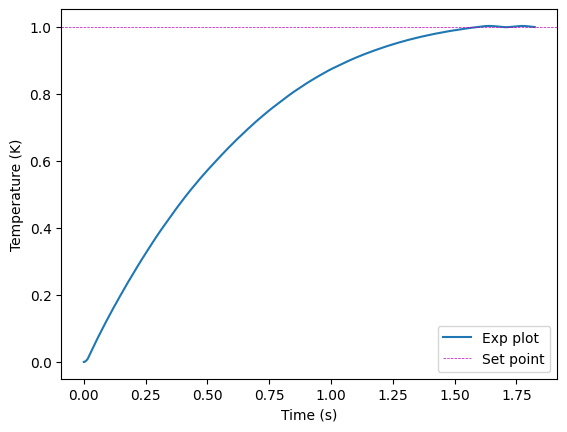

In [41]:
[elapsed_time_seconds, tempcol] = log_file_reader("templog_2024-09-13_12-50-37_to_2024-09-13_14-40-03.txt")

basic_plotter('Exp plot', elapsed_time_seconds/3600, normalise(tempcol, 77), 1, False)

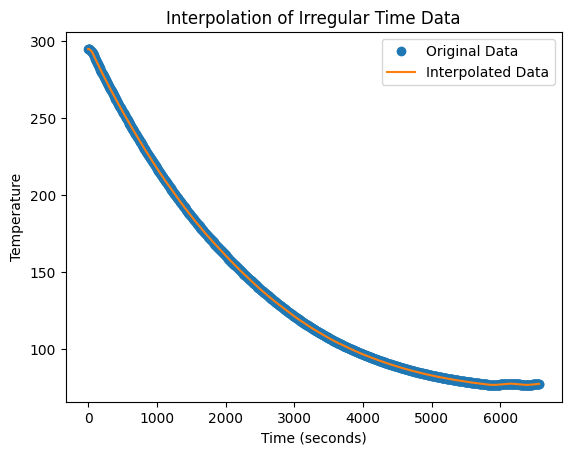

Data saved to 'interpolated_data.txt'


In [42]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
elapsed_time_seconds = np.array(elapsed_time_seconds)
tempcol = np.array(tempcol)

# Define the regular grid
regular_time = np.arange(0, max(elapsed_time_seconds), 1)  # Regular intervals (0.1 seconds)

# Interpolate using linear interpolation
interp_function = interp.interp1d(elapsed_time_seconds, tempcol, kind='linear', fill_value="extrapolate")
regular_temp = interp_function(regular_time)

# Plotting for visualization
plt.plot(elapsed_time_seconds, tempcol, 'o', label='Original Data')
plt.plot(regular_time, regular_temp, '-', label='Interpolated Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature')
plt.legend()
plt.title('Interpolation of Irregular Time Data')
plt.show()

data_to_save = np.column_stack((regular_time, regular_temp))

# Save to a .txt file in CSV format
np.savetxt('interpolated_data_77k.txt', data_to_save, delimiter=',')

print("Data saved to 'interpolated_data.txt'")

tempcol = tempcol.tolist()
elapsed_time_seconds = elapsed_time_seconds.tolist()
regular_time = regular_time.tolist()
regular_temp = regular_temp.tolist()

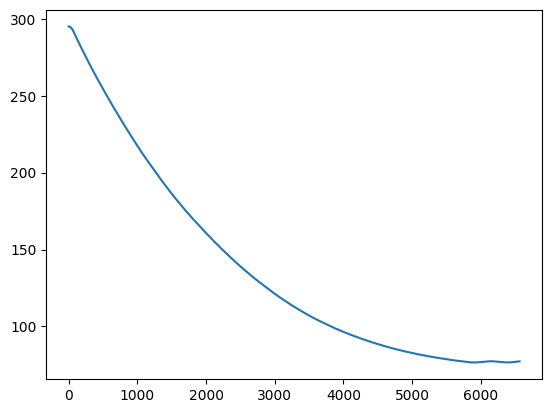

In [43]:
plt.plot(regular_time, regular_temp)

### CHARACTERIZE THE LOG DATA
### PLOTTING THE CLOSED LOOP TF OF EXPERIMENT, MODEL, AFTER TUNING

Peak temperature: 76.58 K
Percentage overshoot: -0.545 %
Peak time: 5898.0 s
Rise time: 4942.636 s
Damping Factor: 0.85641737
Natural Frequency: 0.00103171 rad/s


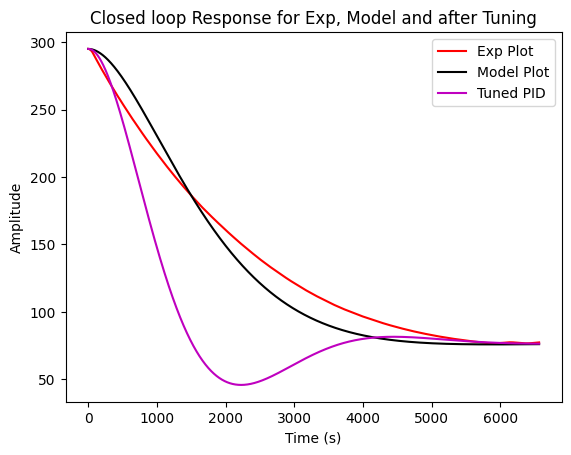

In [44]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(elapsed_time_seconds, tempcol, set_t)

[t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, P, C, T] = model_and_tuned_system_maker(w_n, damp_f, 5, 0.5, 0.2, 5, 0.5, 0.2, 5, 1.3, 0, 0, 6566)

exp_model_tuned_plotter(elapsed_time_seconds, tempcol, t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, set_t, False)

##### Open loop Plant TF

In [45]:
P

TransferFunction(array([1.06441915e-06]), array([2.00000000e-01, 5.00035343e+00, 5.08835717e-01, 8.83571717e-04]))

##### Controller TF

In [46]:
C

TransferFunction(array([0.2, 5. , 0.5]), array([1, 0]))

##### Overall TF with feedback

In [47]:
T

TransferFunction(array([2.12883830e-07, 5.32209574e-06, 5.32209574e-07]), array([2.00000000e-01, 5.00035343e+00, 5.08835930e-01, 8.88893813e-04,
       5.32209574e-07]))

#### CHARACTERIZE THE LOG DATA

Peak temperature: 76.58 K
Percentage overshoot: -0.545 %
Peak time: 5898.0 s
Rise time: 4942.636 s
Damping Factor: 0.85641737
Natural Frequency: 0.00103171 rad/s


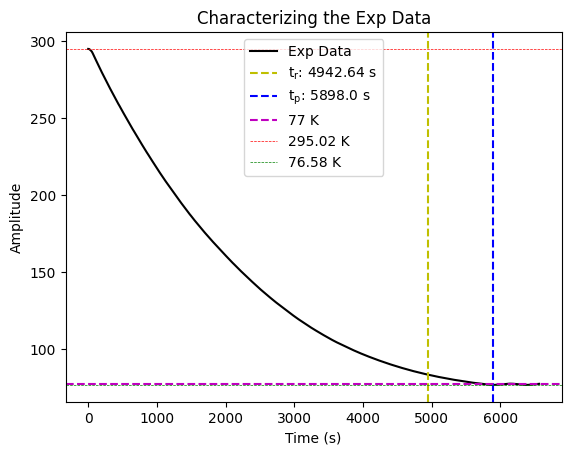

In [48]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(elapsed_time_seconds, tempcol, set_t)
characterized_system_plotter('Exp Data', elapsed_time_seconds, tempcol, rise_time, peak_time, set_t, True)

### CHARACTERIZING THE MODEL DATA

Peak temperature: 75.81080000583529 K
Percentage overshoot: -1.544 %
Peak time: 5898.0 s
Rise time: 4785.588 s
Damping Factor: 0.79873888
Natural Frequency: 0.00088528 rad/s


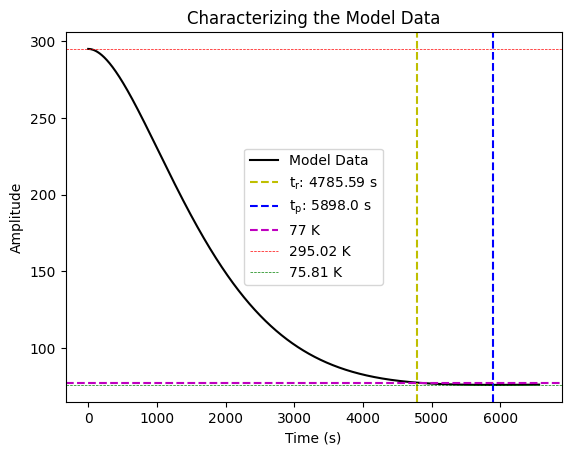

In [49]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(t_model, y_model_unnorm, set_t)
characterized_system_plotter('Model Data', t_model, y_model_unnorm, rise_time, peak_time, set_t, True)

### CHARACTERIZING THE TUNED DATA

Peak temperature: 45.76111276905064 K
Percentage overshoot: -40.57 %
Peak time: 2226.81 s
Rise time: 1467.972 s
Damping Factor: 0.27600612
Natural Frequency: 0.00146782 rad/s


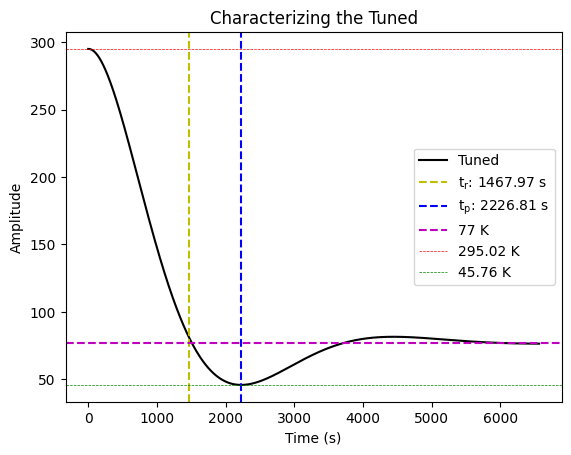

In [50]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(t_model, y_tuned_unnorm, set_t)
characterized_system_plotter('Tuned', t_tuned, y_tuned_unnorm, rise_time, peak_time, set_t, True)

### Copper Model

In [51]:
#copper plate model
r = 3.5/200 #m
r_cu = 15/200 # metres
k = 385
l = 0.6/100  #length of cold tip
l_cu = 0.5/100
pho_cu = 9000 # kg/m3
c_cu = 385  # J/(Kg.K)

a = math.pi * r * r
a_cu = math.pi * r_cu * r_cu
mass_cu = a_cu * l_cu * pho_cu
mass = a * l * pho_cu

r_const = (1/k) * ((l_cu/a_cu) + (l/a))
# + (l/a)

copper_plate_TF = 1 + (r_const * (mass + mass_cu) * c_cu * s)
print(copper_plate_TF)

print(T)

time, y_cu, T = custom_model_maker(P, C, copper_plate_TF,0,6566)
[y_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(time, y_cu, set_t)

<TransferFunction>: sys[78]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


5.523 s + 1
-----------
     1

<TransferFunction>: sys[68]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       2.129e-07 s^2 + 5.322e-06 s + 5.322e-07
------------------------------------------------------
0.2 s^4 + 5 s^3 + 0.5088 s^2 + 0.0008889 s + 5.322e-07

<TransferFunction>: sys[82]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1.176e-06 s^3 + 2.961e-05 s^2 + 8.261e-06 s + 5.322e-07
-------------------------------------------------------
0.2 s^4 + 5 s^3 + 0.5089 s^2 + 0.0008918 s + 5.322e-07

Peak temperature: 75.8866762068906 K
Percentage overshoot: -1.446 %
Peak time: 5947.28 s
Rise time: 4836.836 s
Damping Factor: 0.80324172
Natural Frequency: 0.00088683 rad/s


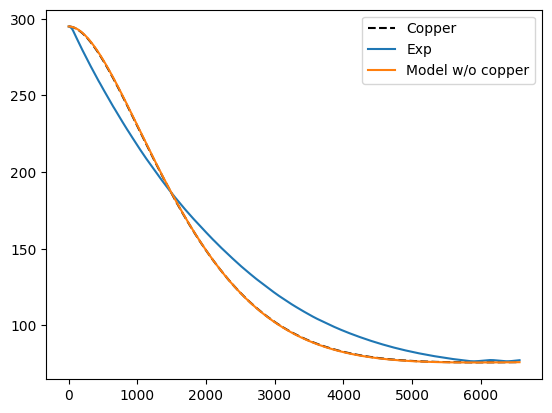

In [60]:
plt.plot(time, y_cu, label = 'Copper', color='k', linestyle='--')
plt.plot(elapsed_time_seconds, tempcol, label = 'Exp')
plt.plot(t_model, y_model_unnorm, label = 'Model w/o copper')
plt.legend()

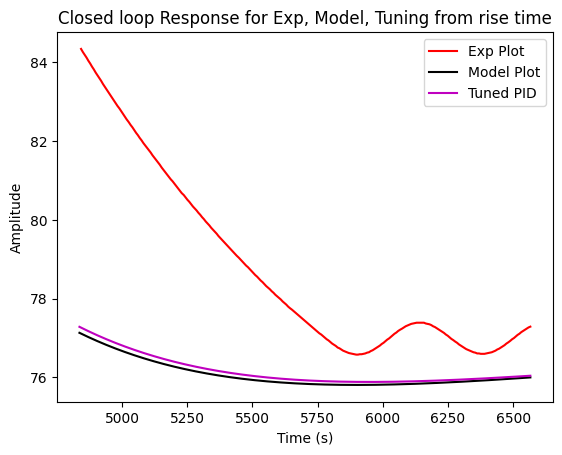

In [61]:
exp_model_tuned_plotter_endtime(elapsed_time_seconds, tempcol, t_model, y_model_unnorm, time, y_cu, set_t, False, rise_time)

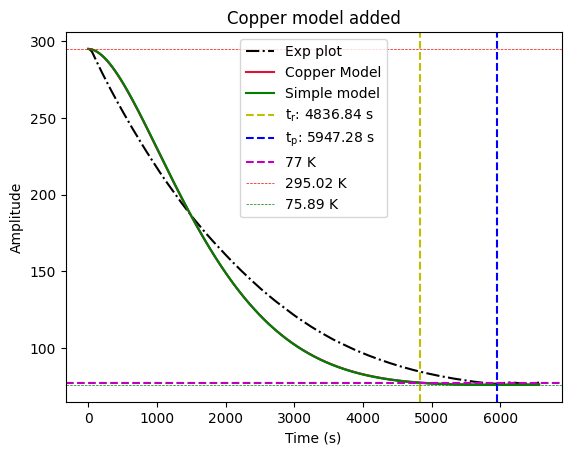

In [62]:
plt.plot(time, y_cu)
characterized_copper_system_plotter("Copper Model", 'Exp plot', 'Simple model', time, y_cu, elapsed_time_seconds, tempcol, t_model, y_model_unnorm, rise_time, peak_time, set_t, True)

array([[list([<matplotlib.lines.Line2D object at 0x00000149878C4050>]),
        list([<matplotlib.lines.Line2D object at 0x00000149879F7F90>]),
        list([<matplotlib.lines.Line2D object at 0x00000149879F5ED0>, <matplotlib.lines.Line2D object at 0x00000149879F5C50>, <matplotlib.lines.Line2D object at 0x00000149879F76D0>, <matplotlib.lines.Line2D object at 0x00000149879F72D0>])]],
      dtype=object)

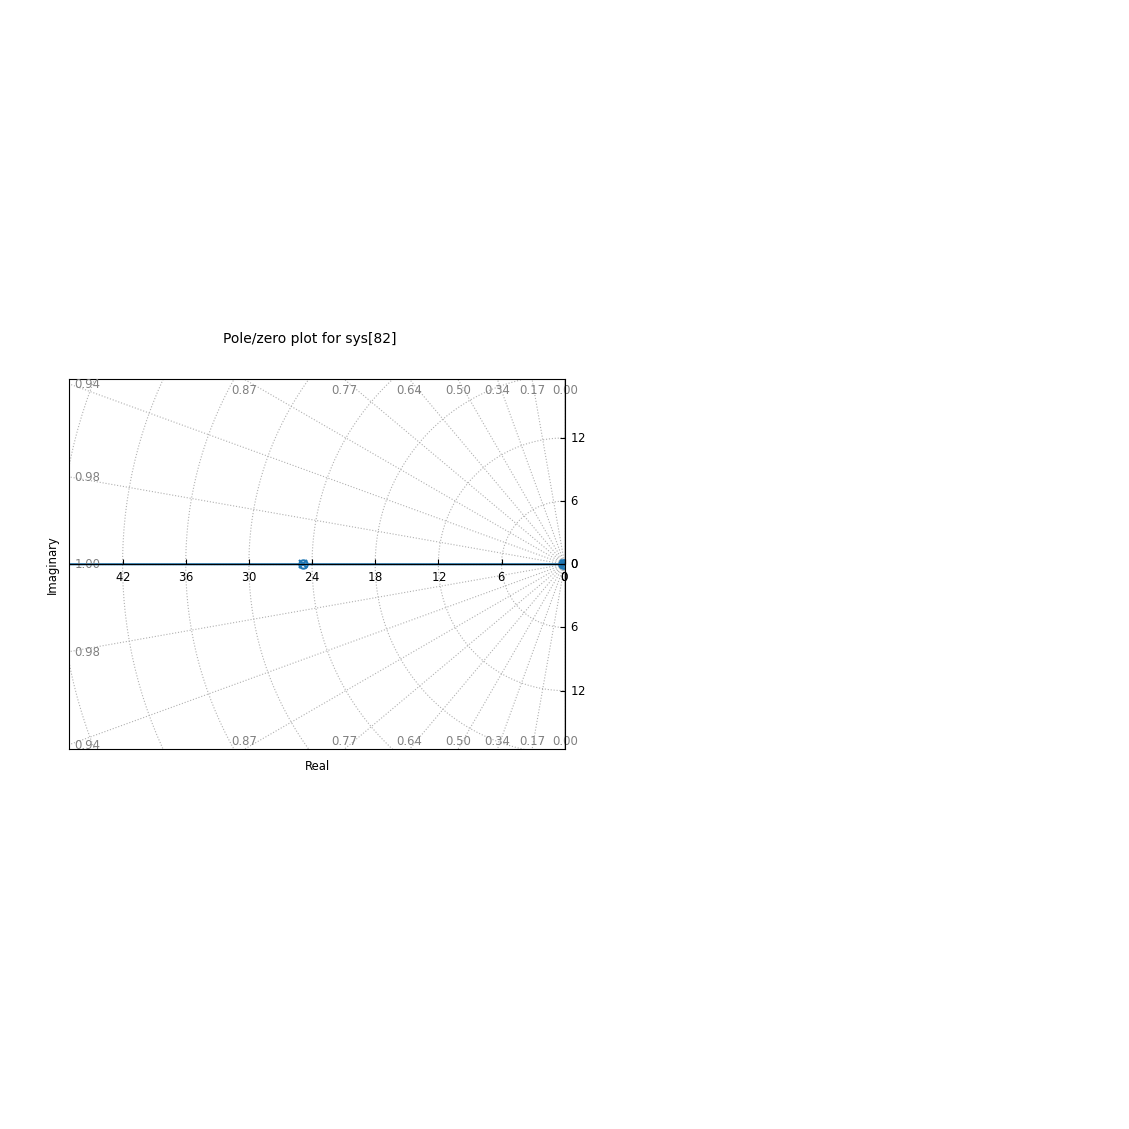

In [63]:
ct.root_locus_map(T).plot()

In [64]:
poles = ct.poles(T)
zeros = ct.zeros(T)


# Function to format poles and zeros
def format_complex_array(arr):
    formatted = []
    for num in arr:
        # If the imaginary part is very close to zero, just print the real part
        if np.isclose(num.imag, 0):
            formatted.append(f"{num.real:.6f}")
        else:
            formatted.append(f"{num.real:.6f} + {num.imag:.6f}j")
    return formatted

# Format poles and zeros
formatted_poles = format_complex_array(poles)
formatted_zeros = format_complex_array(zeros)

print("Poles:", formatted_poles)
print("Zeros:", formatted_zeros)

Poles: ['-24.899597', '-0.100403', '-0.000887 + 0.000528j', '-0.000887 + -0.000528j']
Zeros: ['-24.899597', '-0.181065', '-0.100403']


##### Checking which mass works best

<TransferFunction>: sys[142]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-1.176e-06 s^3 - 2.918e-05 s^2 + 2.383e-06 s + 5.322e-07
--------------------------------------------------------
 0.2 s^4 + 5 s^3 + 0.5088 s^2 + 0.000886 s + 5.322e-07

Peak temperature: 75.73197881356694 K
Percentage overshoot: -1.647 %
Peak time: 5850.32 s
Rise time: 4735.942 s
Damping Factor: 0.79422302
Natural Frequency: 0.00088376 rad/s
<TransferFunction>: sys[152]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1.27e-05 s^3 + 0.0003178 s^2 + 3.708e-05 s + 5.322e-07
------------------------------------------------------
0.2 s^4 + 5 s^3 + 0.5092 s^2 + 0.0009207 s + 5.322e-07

Peak temperature: 76.4801913215407 K
Percentage overshoot: -0.675 %
Peak time: 6536.64 s
Rise time: 5445.632 s
Damping Factor: 0.8466419
Natural Frequency: 0.00090313 rad/s
<TransferFunction>: sys[162]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


2.658e-05 s^3 + 0.0006647 s^2 + 7.177e-05 s + 5.322e-07
--------------------------------------

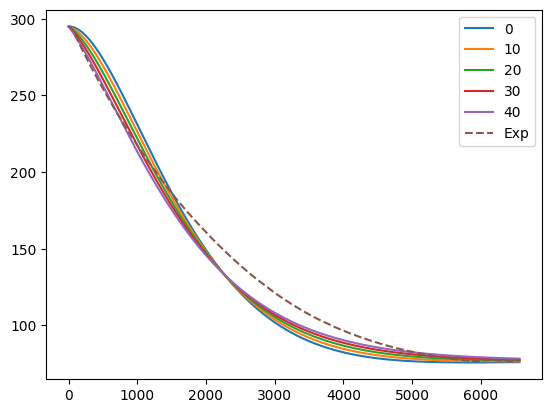

In [66]:
for temp in range(0,50,10):
    copper_plate_TF = 1 - (r_const * (mass + mass_cu - temp) * c_cu * s)
    time, y_cu, T = custom_model_maker(P, C, copper_plate_TF,0,6566)
    [y_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(time, y_cu, set_t)

    plt.plot(time, y_cu, label = f'{temp}')

plt.plot(elapsed_time_seconds, tempcol, label = 'Exp', linestyle='--')
plt.legend()